In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice
import random

In [2]:
import wandb

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from pytorch_lightning.loggers import WandbLogger

from estimator import LagTransformerEstimator

[2023-07-02 13:06:51,494] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

In [4]:
class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)
    
    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

In [5]:
gluonts_ds = [
        get_dataset("airpassengers").train,
        get_dataset("australian_electricity_demand").train,
        get_dataset("car_parts_without_missing").train,
        get_dataset("cif_2016").train,
        get_dataset("covid_deaths").train,
        get_dataset("electricity").train,
        get_dataset("electricity_weekly").train,
        get_dataset("exchange_rate").train,
        get_dataset("fred_md").train,
        get_dataset("hospital").train,
        get_dataset("kaggle_web_traffic_weekly").train,
        get_dataset("kdd_cup_2018_without_missing").train,
        get_dataset("london_smart_meters_without_missing").train,
        get_dataset("nn5_daily_with_missing").train,
        get_dataset("nn5_weekly").train,
        get_dataset("pedestrian_counts").train,
        get_dataset("rideshare_without_missing").train,
        get_dataset("saugeenday").train,
        get_dataset("solar-energy").train,
        get_dataset("solar_10_minutes").train,
        get_dataset("solar_weekly").train,
        get_dataset("taxi_30min").train,
        get_dataset("temperature_rain_without_missing").train,
        get_dataset("tourism_monthly").train,
        get_dataset("uber_tlc_daily").train,
        get_dataset("uber_tlc_hourly").train,
        get_dataset("vehicle_trips_without_missing").train,
        get_dataset("weather").train,
        get_dataset("wiki-rolling_nips").train,
        get_dataset("m4_daily").train,
        get_dataset("m4_hourly").train,
        get_dataset("m4_monthly").train,
        get_dataset("m4_quarterly").train,
        get_dataset("m4_yearly").train,
        get_dataset("wind_farms_without_missing").train,
]
dataset = CombinedDataset(gluonts_ds, weights=[sum([len(x["target"]) for x in d]) for d in gluonts_ds])

In [6]:
val_dataset = get_dataset("m4_weekly").test

In [7]:
meta = get_dataset("m4_weekly").metadata

In [8]:
meta

MetaData(freq='W', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='359')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=13)

In [13]:
estimator = LagTransformerEstimator(
    prediction_length=512,
    context_length=512, # block_size: int = 2048 
    batch_size=16, # 4
    num_encoder_layers=4,
    num_decoder_layers=4,
    nhead=4,
    d_model=128, # 4096
    dim_feedforward=128*2,
    scaling="std",
    
    aug_prob=1.0,
    aug_rate=0.2,
    
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=300, accelerator="gpu", precision="bf16-mixed", logger=WandbLogger()),
)

In [ ]:
predictor_output = estimator.train_model(
    training_data=dataset, 
    validation_data=val_dataset,
    shuffle_buffer_length=1024,
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because self.layers[0].norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precisio

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'val_loss' reached 8.95447 (best 8.95447), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' reached 8.20913 (best 8.20913), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=1-step=200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' reached 7.87121 (best 7.87121), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=3-step=400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 600: 'val_loss' reached 7.82722 (best 7.82722), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=5-step=600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 800: 'val_loss' reached 7.80906 (best 7.80906), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=7-step=800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 900: 'val_loss' reached 7.68085 (best 7.68085), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=8-step=900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1000: 'val_loss' reached 7.52965 (best 7.52965), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=9-step=1000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1300: 'val_loss' reached 7.41739 (best 7.41739), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=12-step=1300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1500: 'val_loss' reached 7.38766 (best 7.38766), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=14-step=1500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2000: 'val_loss' reached 7.35032 (best 7.35032), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=19-step=2000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 2100: 'val_loss' reached 7.29327 (best 7.29327), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=20-step=2100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 2400: 'val_loss' reached 7.25743 (best 7.25743), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=23-step=2400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 2500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 2700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 2800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 2900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 3000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3200: 'val_loss' reached 7.24169 (best 7.24169), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=31-step=3200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 3300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 3600: 'val_loss' reached 7.23089 (best 7.23089), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=35-step=3600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 3700: 'val_loss' reached 7.17775 (best 7.17775), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=36-step=3700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 3800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 3900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4000: 'val_loss' reached 7.14619 (best 7.14619), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=39-step=4000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4100: 'val_loss' reached 7.10731 (best 7.10731), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=40-step=4100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4200: 'val_loss' reached 7.06322 (best 7.06322), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=41-step=4200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 4400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 4500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 4600: 'val_loss' reached 6.99551 (best 6.99551), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=45-step=4600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 4700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 4800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 4900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 5100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 5200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 5300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 5400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 5500: 'val_loss' reached 6.99208 (best 6.99208), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=54-step=5500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 5600: 'val_loss' reached 6.99158 (best 6.99158), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=55-step=5600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 5700: 'val_loss' reached 6.95716 (best 6.95716), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=56-step=5700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 5800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 5900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 6000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 6100: 'val_loss' reached 6.92316 (best 6.92316), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=60-step=6100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 6200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 6300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 6400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 6500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 6600: 'val_loss' reached 6.90251 (best 6.90251), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=65-step=6600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 6700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 6800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 6900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 7000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 7100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 7200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 7300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 7400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 7500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 75, global step 7600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 7700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 7800: 'val_loss' reached 6.82939 (best 6.82939), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=77-step=7800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 7900: 'val_loss' reached 6.82595 (best 6.82595), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=78-step=7900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 8000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 8100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 8200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 8300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 8400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 8500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 8600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 8700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 8800: 'val_loss' reached 6.75783 (best 6.75783), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=87-step=8800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 8900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 9000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 9100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 9200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 9300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 9400: 'val_loss' reached 6.74058 (best 6.74058), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=93-step=9400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 9500: 'val_loss' reached 6.73888 (best 6.73888), saving model to './lightning_logs/za8xtdpf/checkpoints/epoch=94-step=9500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 9600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 9700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 9800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 9900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 10000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 100, global step 10100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 101, global step 10200: 'val_loss' was not in top 1


In [7]:
test_dataset = get_dataset("traffic").test

In [12]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset, predictor=predictor
)

In [13]:
forecasts = list(forecast_it)

In [14]:
tss = list(ts_it)

In [15]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(
    iter(tss), iter(forecasts), num_series=len(test_dataset)
)

Running evaluation: 100%|█████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 81499.18it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to 

In [16]:
agg_metrics

{'MSE': 0.0012039882780453695,
 'abs_error': 2842.3468379192054,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 1.3284552483291845,
 'MAPE': 0.930016540289234,
 'sMAPE': 0.41002948484625845,
 'MSIS': 12.91386256315466,
 'QuantileLoss[0.1]': 1396.3432642059154,
 'Coverage[0.1]': 0.07537841122527898,
 'QuantileLoss[0.2]': 2107.0061673827386,
 'Coverage[0.2]': 0.18572533421721354,
 'QuantileLoss[0.3]': 2575.773881268628,
 'Coverage[0.3]': 0.2607170478400177,
 'QuantileLoss[0.4]': 2815.2369757124748,
 'Coverage[0.4]': 0.3154416639045409,
 'QuantileLoss[0.5]': 2842.3468341527114,
 'Coverage[0.5]': 0.3738744337642249,
 'QuantileLoss[0.6]': 2708.7602061208454,
 'Coverage[0.6]': 0.45153850403270357,
 'QuantileLoss[0.7]': 2350.6508774530494,
 'Coverage[0.7]': 0.5874005634736493,
 'QuantileLoss[0.8]': 1869.9664942414963,
 'Coverage[0.8]': 0.7701635178433323,
 'QuantileLoss[0.9]': 1316.9552849354918,
 'Coverage[0.9]': 

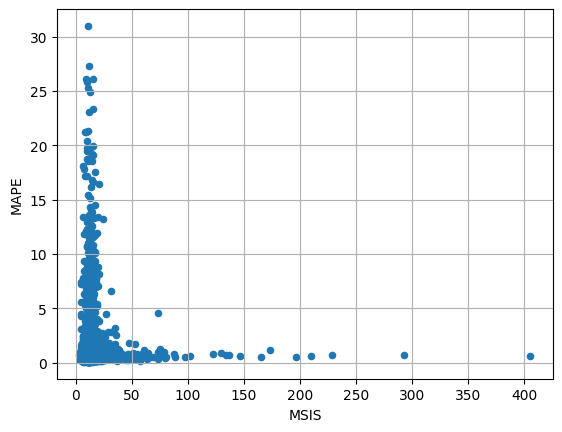

In [17]:
ts_metrics.plot(x="MSIS", y="MAPE", kind="scatter")
plt.grid(which="both")
plt.show()

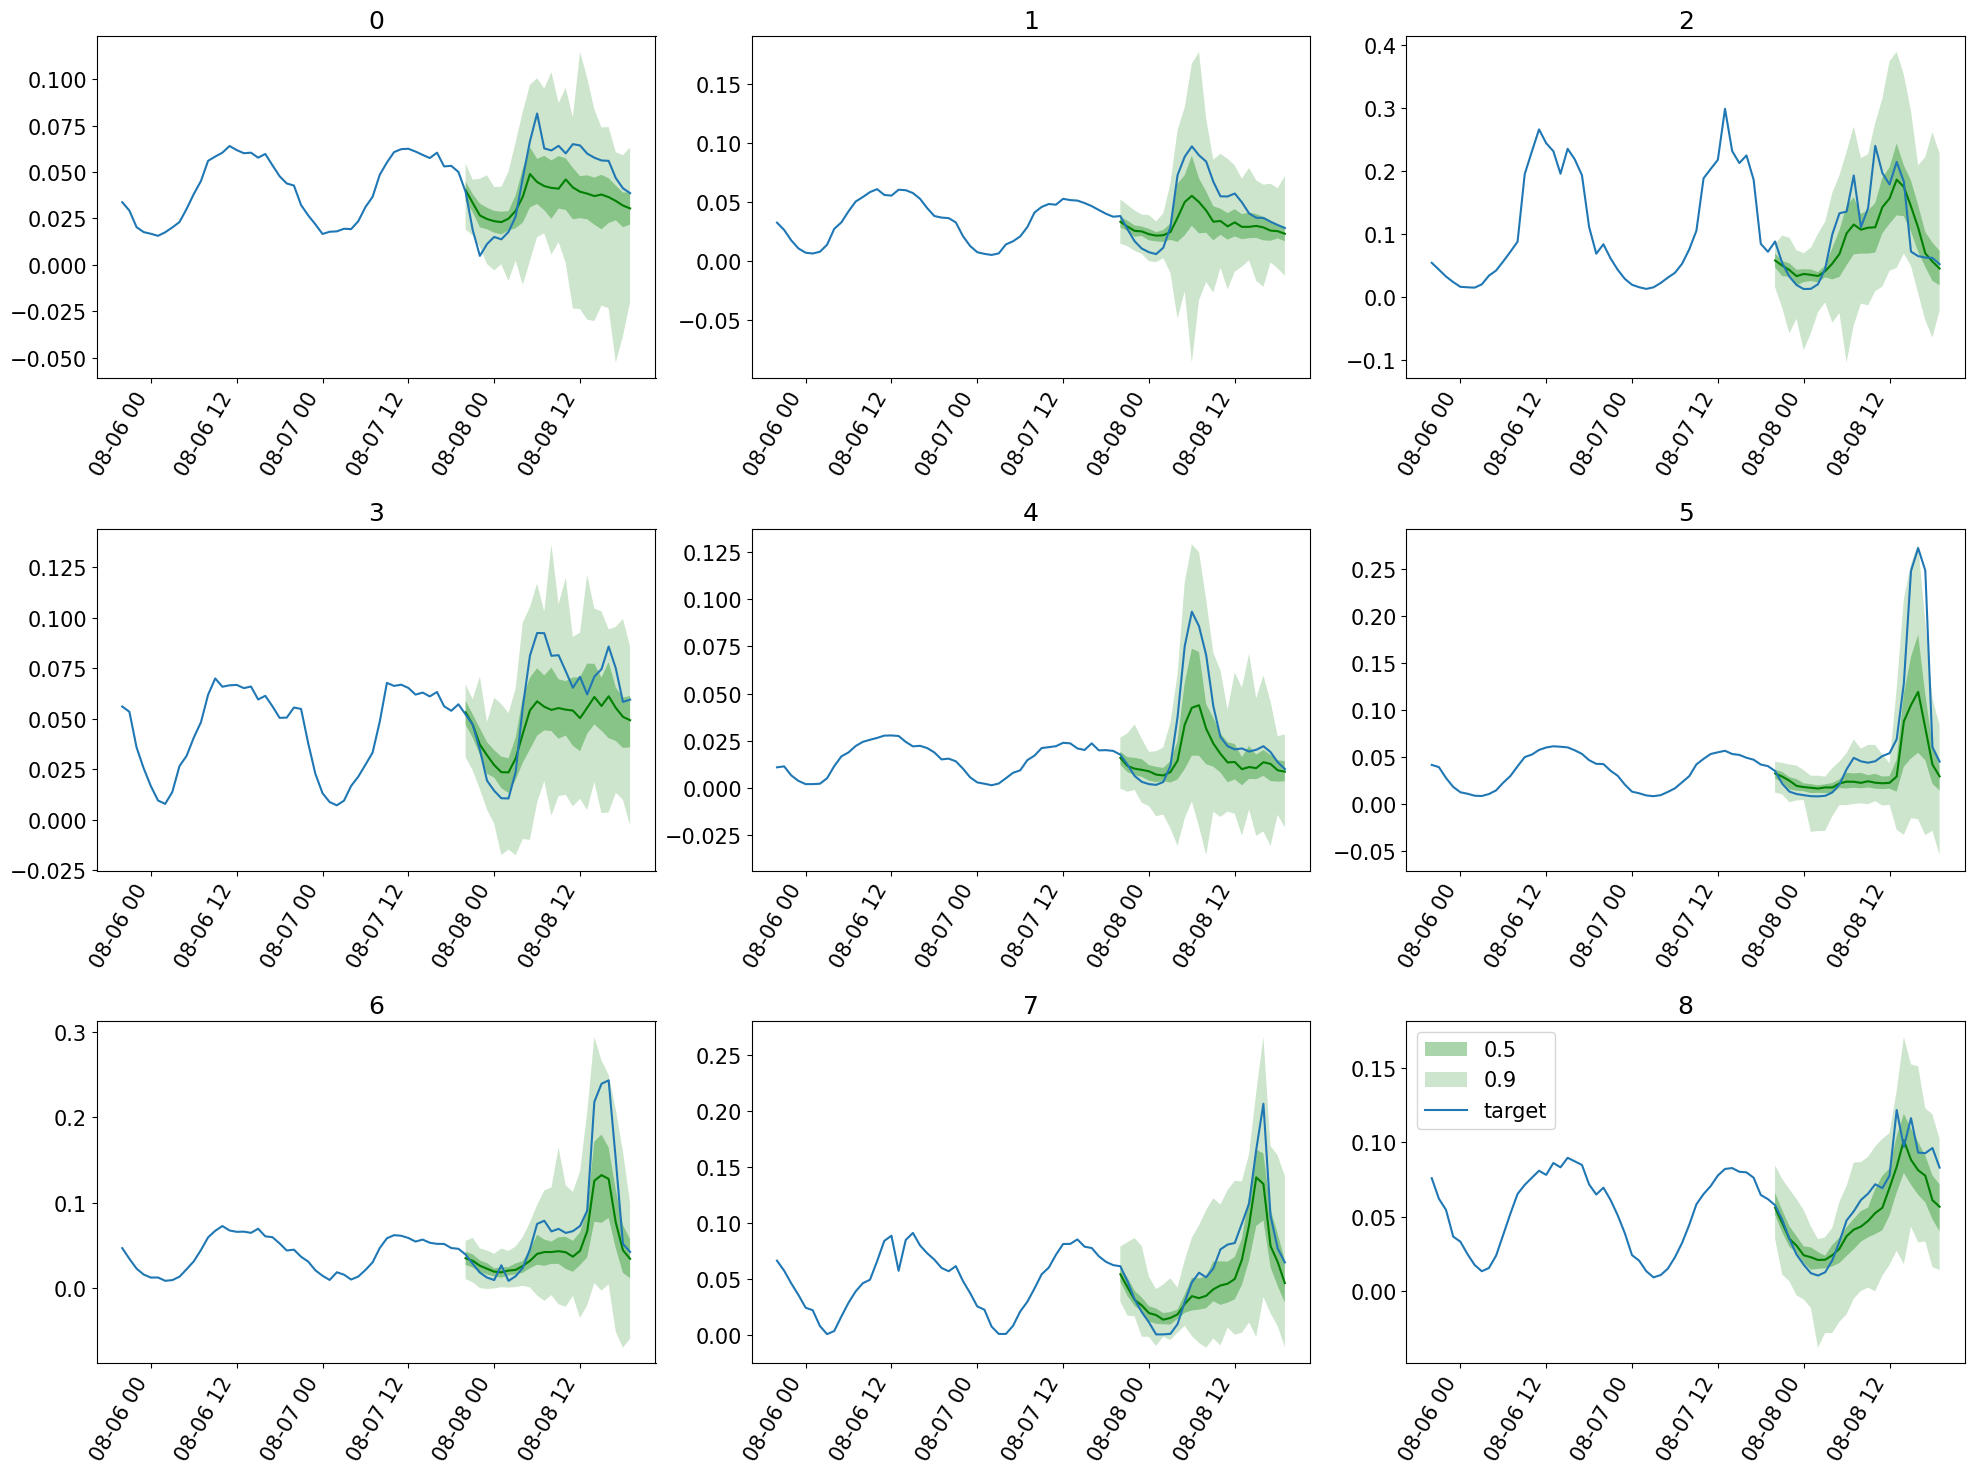

In [19]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g', show_label=True)
    ts[-3 * 24:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()